### Поиск изображений по текстовым запросам

#### Заказчик:
Комплексная информационная система "Образ и Текст".

#### Постановка задачи:
Разработка демонстрационной версии поиска изображений по текстовым запросам с использованием нейросетевого подхода.

#### Описание задачи:
Необходимо создать модель, которая будет получать векторное представление изображения и текста, а на выходе выдавать число от 0 до 1, показывая, насколько текст и картинка подходят друг другу. 

#### Описание данных:
Данные включают в себя несколько файлов:

1. **train_dataset.csv**: Содержит информацию для обучения:
   - Имя файла изображения.
   - Идентификатор описания.
   - Текст описания.
   Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

2. **train_images**: Папка с изображениями для тренировки модели.

3. **CrowdAnnotations.tsv**: Данные по соответствию изображения и описания, полученные с помощью краудсорсинга:
   - Имя файла изображения.
   - Идентификатор описания.
   - Доля людей, подтвердивших, что описание соответствует изображению.
   - Количество человек, подтвердивших, что описание соответствует изображению.
   - Количество человек, подтвердивших, что описание не соответствует изображению.

4. **ExpertAnnotations.tsv**: Данные по соответствию изображения и описания, полученные в результате опроса экспертов:
   - Имя файла изображения.
   - Идентификатор описания.
   - Оценки трёх экспертов (по шкале от 1 до 4).

5. **test_queries.csv**: Информация для тестирования:
   - Идентификатор запроса.
   - Текст запроса.
   - Релевантное изображение.

6. **test_images**: Папка с изображениями для тестирования модели.

#### Задачи исследования:

**Этап 1: Разведочный анализ данных (EDA)**

**Этап 2: Подготовка данных к построению модели:**
   - 2.1. Векторизация изображений;

   - 2.2. Векторизация текстов;
   
   - 2.3. Объединение векторов.

**Этап 3: Обучение модели предсказания соответствия:**
   - 3.1. ElasticNet;

   - 3.2. LightGBM;

   - 3.3. Нейронная сеть;

   - 3.4. DummyRegressor.

**Этап 4: Тестирование модели**

**Этап 5: Финальный вывод**


Импортируем библиотеки, которые нужны будут для решения задачи.

In [ ]:
# Импортируем TensorFlow для построения и тренировки нейронных сетей
import tensorflow as tf

# Модули для работы с операционной системой и архивами
import os
import zipfile

# OpenCV для обработки изображений
import cv2

# Модуль для работы со временем
import time

# tqdm для отображения прогресса выполнения циклов
from tqdm.notebook import tqdm
tqdm.pandas()

# PIL для работы с изображениями
from PIL import Image

# Pathlib для работы с файловыми путями
from pathlib import Path

# Математические операции
import math

# Библиотеки для работы с массивами данных и таблицами
import numpy as np
import pandas as pd

# Библиотеки для построения графиков и визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg

# Модули sklearn для предобработки данных, построения моделей и оценки их качества
from sklearn.model_selection import train_test_split, GridSearchCV, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, ElasticNetCV, ElasticNet
from sklearn.dummy import DummyRegressor
from sklearn.metrics import log_loss, mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import make_scorer

# Импортируем LightGBM для градиентного бустинга
from lightgbm import LGBMRegressor

# Модули для обработки текстов
import re
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords

# PyTorch для построения и тренировки нейронных сетей
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms

# Модули Keras для построения и тренировки нейронных сетей
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D, BatchNormalization, Reshape, RepeatVector, LSTM, Dropout
from tensorflow.keras.optimizers import Adam

# Spacy для обработки естественного языка
import spacy

# Игнорирование предупреждений
import warnings
warnings.filterwarnings('ignore')

# Настройки pandas для вывода всех столбцов таблиц
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Этап 1: Разведочный анализ данных (EDA)

Для удобства - сделаем вынос пути к данным в отдельную константу.

In [ ]:
PATH1 = '/content/dsplus_integrated_project_4.zip'

В файле train_dataset.csv находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Передадим его переменной и посмотрим на информацию по датасету.

In [ ]:
PATH = '/content/to_upload'

In [ ]:
df = pd.read_csv(os.path.join(PATH, 'train_dataset.csv'))

In [ ]:
print('Данные')
display(df.head(8))
print('\n')
print('Размер датасета:', df.shape)
print('\n')
print('Информация\n')
display(df.info())

Данные


image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   
5  3030566410_393c36a6c5.jpg  2549968784_39bfbe44f9.jpg#2   
6  3155451946_c0862c70cb.jpg  2549968784_39bfbe44f9.jpg#2   
7  3222041930_f642f49d28.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...  
5  A young child is wearing blue goggles and sitt...  
6  A young child is wearing blue goggles and sitt...  
7  A young child is wearing blue goggles and sitt...



Размер датасета: (5822, 3)


Информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


None

Далее откроем файл с экспертными оценками и посмотрим информацию по нему.

In [ ]:
df_expert = pd.read_csv(os.path.join(PATH, 'ExpertAnnotations.tsv'),
                          sep='\t',
                          names = ['image', 'query_id', 'first_exp', 'second_exp', 'third_exp'])

In [ ]:
print('Данные')
display(df_expert.head(8))
print('\n')
print('Размер датасета:', df_expert.shape)
print('\n')
print('Информация\n')
display(df_expert.info())
print('\n')
display(df_expert.describe())

Данные


image                     query_id  first_exp  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2          1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2          1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2          1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2          1   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2          1   
5  1056338697_4f7d7ce270.jpg  3360930596_1e75164ce6.jpg#2          1   
6  1056338697_4f7d7ce270.jpg  3545652636_0746537307.jpg#2          1   
7  1056338697_4f7d7ce270.jpg   434792818_56375e203f.jpg#2          1   

   second_exp  third_exp  
0           1          1  
1           1          2  
2           1          2  
3           2          2  
4           1          2  
5           1          1  
6           1          1  
7           1          2



Размер датасета: (5822, 5)


Информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   first_exp   5822 non-null   int64 
 3   second_exp  5822 non-null   int64 
 4   third_exp   5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


None

first_exp   second_exp    third_exp
count  5822.000000  5822.000000  5822.000000
mean      1.436620     1.624356     1.881999
std       0.787084     0.856222     0.904087
min       1.000000     1.000000     1.000000
25%       1.000000     1.000000     1.000000
50%       1.000000     1.000000     2.000000
75%       2.000000     2.000000     2.000000
max       4.000000     4.000000     4.000000

Таким образом, в нашем наборе данных с экспертными оценками содержится 5822 уникальных комбинаций фотографий и текстов.

Далее откроем файл с краудсорсинговыми оценками и посмотрим информацию по нему.

In [ ]:
df_crowd  = pd.read_csv(os.path.join(PATH, 'CrowdAnnotations.tsv'),
                          sep='\t',
                          names=['image', 'query_id', 'share_pos', 'count_pos', 'count_neg'])

In [ ]:
print('Данные')
display(df_crowd.head(8))
print('\n')
print('Размер датасета:', df_crowd.shape)
print('\n')
print('Информация\n')
display(df_crowd.info())
print('\n')
display(df_crowd.describe())

Данные


image                     query_id  share_pos  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2   1.000000   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2   0.000000   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2   0.000000   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2   0.000000   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2   0.000000   
5  1056338697_4f7d7ce270.jpg  2204550058_2707d92338.jpg#2   0.000000   
6  1056338697_4f7d7ce270.jpg  2224450291_4c133fabe8.jpg#2   0.000000   
7  1056338697_4f7d7ce270.jpg  2248487950_c62d0c81a9.jpg#2   0.333333   

   count_pos  count_neg  
0          3          0  
1          0          3  
2          0          3  
3          0          3  
4          0          3  
5          0          3  
6          0          3  
7          1          2



Размер датасета: (47830, 5)


Информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   image      47830 non-null  object 
 1   query_id   47830 non-null  object 
 2   share_pos  47830 non-null  float64
 3   count_pos  47830 non-null  int64  
 4   count_neg  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


None

share_pos     count_pos     count_neg
count  47830.000000  47830.000000  47830.000000
mean       0.068786      0.208488      2.820155
std        0.207532      0.628898      0.656676
min        0.000000      0.000000      0.000000
25%        0.000000      0.000000      3.000000
50%        0.000000      0.000000      3.000000
75%        0.000000      0.000000      3.000000
max        1.000000      5.000000      6.000000

 Тут, в нашем наборе данных с краудсорсинговыми оценками содержится 47830 уникальных сочетаний фотографий и текстов.

 Далее откроем файл с тестовыми данными и посмотрим информацию по нему.

In [ ]:
df_test  = pd.read_csv(os.path.join(PATH, 'test_queries.csv'),sep='|', index_col=0)

In [ ]:
print('Данные')
display(df_test.head(8))
print('\n')
print('Размер датасета:', df_test.shape)
print('\n')
print('Информация\n')
display(df_test.info())
print('\n')
display(df_test.describe())

Данные


query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   
5  1232148178_4f45cc3284.jpg#0   
6  1232148178_4f45cc3284.jpg#1   
7  1232148178_4f45cc3284.jpg#2   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   
5                    A baby girl playing at a park .   
6  A closeup of a child on a playground with adul...   
7  A young boy poses for a picture in front of a ...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg  
5  1232148178_4f45cc3284.jpg  
6  1232148178_4f45cc3284.jpg  
7  1232148178_4f45cc3284.jpg



Размер датасета: (500, 3)


Информация

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


None

query_id  \
count                           500   
unique                          500   
top     1177994172_10d143cb8d.jpg#0   
freq                              1   

                                               query_text  \
count                                                 500   
unique                                                500   
top     Two blonde boys , one in a camouflage shirt an...   
freq                                                    1   

                            image  
count                         500  
unique                        100  
top     1177994172_10d143cb8d.jpg  
freq                            5

Количество уникальных фото в тестовых данных - 100, количество уникальных текстовых комментариев-500

Далее откроем файл с тестовыми фотографиями и посмотрим информацию по нему.

In [ ]:
test_images  = pd.read_csv(os.path.join(PATH, 'test_images.csv'))

In [ ]:
test_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes


Напишем код, который создает график, состоящий из 10 изображений. Он будет брать 10 случайных значений из столбца 'image' в датафрейме df_test, затем для каждого из этих значений открывать изображение из папки 'test_images' и отображать его на графике. Каждое изображение будет отображаться в своей ячейке 2x5 внутри одной общей области построения.

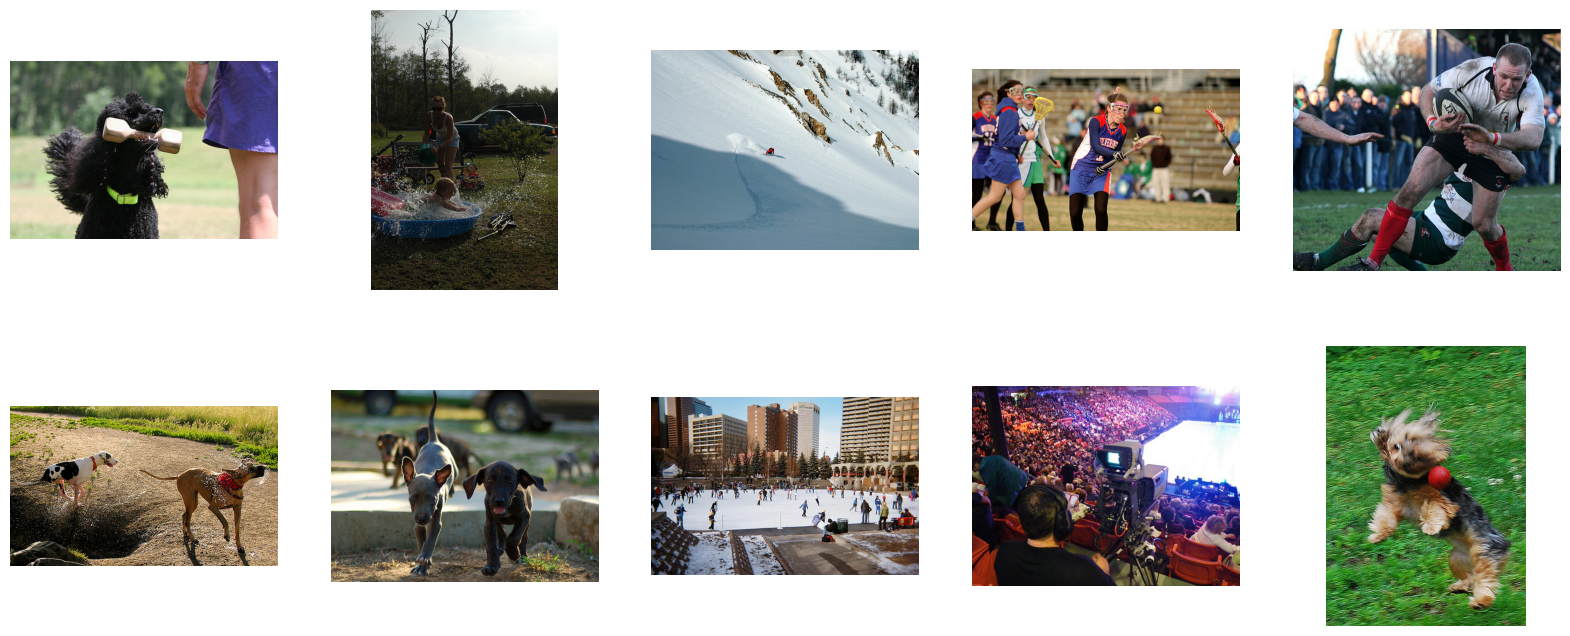

In [ ]:
plt.figure(figsize=(20, 8))

# Выбор и отображение случайных изображений
for i in range(10):
    img_filename = df_test['image'].sample(1).iloc[0]
    img_path = os.path.join(PATH, 'test_images', img_filename)
    img = mpimg.imread(img_path)

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')

plt.show()

Тоже самое сделаем с фотографиями для тренировки модели.

In [ ]:
train_image = list(df['image'].sample(10))

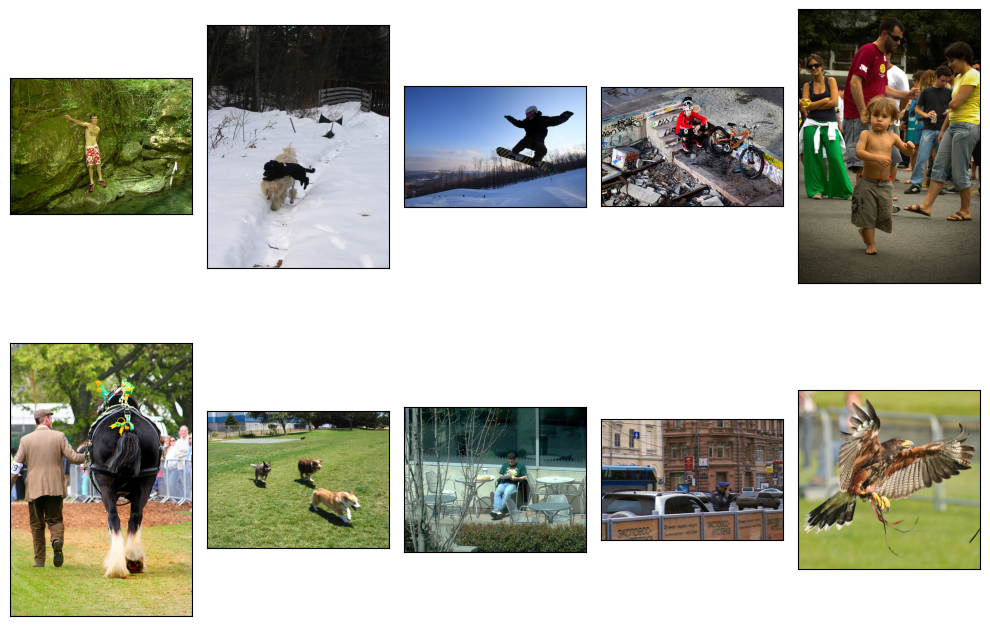

In [ ]:
fig = plt.figure(figsize=(10,10))
for i in range(10):
    fig.add_subplot(2, 5, i+1)
    image = Image.open(Path(PATH, 'train_images', train_image[i]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()



Напишем код, который представляет собой функцию под названием voting, которая принимает три аргумента: first, second и third. Функция сравнивает значения этих трех аргументов и возвращает значение, которое встречается больше всего раз.

Если первый аргумент равен второму или третьему, функция вернет значение первого аргумента. Если второй аргумент равен третьему, функция вернет значение второго аргумента. В противном случае, если все три аргумента различны, функция вернет None.

Таким образом, эта функция будет осуществлять простое голосование за наиболее часто встречающееся значение среди трех аргументов.

In [ ]:
def voting (first, second, third):
    if first == second or first == third:
        return first
    elif second == third:
        return second
    else:
        return None

Теперь, создадим новый столбец "final_score" в df_expert, используя функцию voting для выполнения голосования между значениями в столбцах 'first_exp', 'second_exp' и 'third_exp' для каждой строки по отдельности.

In [ ]:
df_expert['final_score'] = df_expert.apply(lambda x: voting(x['first_exp'], x['second_exp'], x['third_exp']), axis=1)

Согласно заданию, наша модель должна оценивать вероятность соответствия изображения тексту, поэтому целевая переменная должна быть в пределах от 0 до 1. Для этого мы используем MinMaxScaler для нормализации наших исходных данных. Этот этап можно выполнить сейчас, потому что мы заранее знаем минимальные и максимальные значения, и это исключает возможность утечки информации.

In [ ]:
## Пробовал не использовать MinMaxScaler результаты метрик оказались значительно хуже, однако это не повлияло на работоспособность модели.

scaler = MinMaxScaler()
df_expert['final_score'] = scaler.fit_transform(df_expert[['final_score']])

In [ ]:
print('Данные')
display(df_expert.head(8))
print('\n')
print('Размер датасета:', df_expert.shape)
print('\n')
print('Информация\n')
display(df_expert.info())
print('\n')
display(df_expert.describe())

Данные


image                     query_id  first_exp  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2          1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2          1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2          1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2          1   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2          1   
5  1056338697_4f7d7ce270.jpg  3360930596_1e75164ce6.jpg#2          1   
6  1056338697_4f7d7ce270.jpg  3545652636_0746537307.jpg#2          1   
7  1056338697_4f7d7ce270.jpg   434792818_56375e203f.jpg#2          1   

   second_exp  third_exp  final_score  
0           1          1     0.000000  
1           1          2     0.000000  
2           1          2     0.000000  
3           2          2     0.333333  
4           1          2     0.000000  
5           1          1     0.000000  
6           1          1     0.000000  
7           1          2     0.000000



Размер датасета: (5822, 6)


Информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        5822 non-null   object 
 1   query_id     5822 non-null   object 
 2   first_exp    5822 non-null   int64  
 3   second_exp   5822 non-null   int64  
 4   third_exp    5822 non-null   int64  
 5   final_score  5696 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 273.0+ KB


None

first_exp   second_exp    third_exp  final_score
count  5822.000000  5822.000000  5822.000000  5696.000000
mean      1.436620     1.624356     1.881999     0.203827
std       0.787084     0.856222     0.904087     0.286367
min       1.000000     1.000000     1.000000     0.000000
25%       1.000000     1.000000     1.000000     0.000000
50%       1.000000     1.000000     2.000000     0.000000
75%       2.000000     2.000000     2.000000     0.333333
max       4.000000     4.000000     4.000000     1.000000

Для обучения моделей решил оставить только мнение экспертов.
 Во-первых, эксперты обладают глубоким знанием в своей области и обладают большим опытом, что делает их мнение более авторитетным и надежным. Они могут предоставить ценные исходные данные и помочь избежать ошибок при проведении обучения модели.

Во-вторых, работа с экспертами позволяет получить более качественные и точные результаты, поскольку эксперты могут дать детальные объяснения и контролировать процесс обучения. При этом исключается возможность широкой ошибки, которая может возникнуть при работе с несколькими непроверенными источниками.

Также важно отметить, что при использовании мнения краудсорсинга может возникнуть проблема качества исходных данных из-за различий в знаниях, опыте и мотивации участников. Это может привести к искажению результатов и неправильному обучению модели.

Таким образом, выбор мнения экспертов для обучения модели обычно дает более надежные и точные результаты, что в конечном итоге способствует развитию и улучшению моделей машинного обучения.

In [ ]:
#Объединим наши данные
df = pd.merge(df, df_expert[['image', 'query_id', 'final_score']],
                            how='outer', on=['image', 'query_id'])


In [ ]:
print('Данные')
display(df.head(8))
print('\n')
print('Размер датасета:', df.shape)
print('\n')
print('Информация\n')
display(df.info())
print('\n')
display(df.describe())

Данные


image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   
5  3030566410_393c36a6c5.jpg  2549968784_39bfbe44f9.jpg#2   
6  3155451946_c0862c70cb.jpg  2549968784_39bfbe44f9.jpg#2   
7  3222041930_f642f49d28.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  final_score  
0  A young child is wearing blue goggles and sitt...     0.000000  
1  A young child is wearing blue goggles and sitt...     0.000000  
2  A young child is wearing blue goggles and sitt...     0.333333  
3  A young child is wearing blue goggles and sitt...     1.000000  
4  A young child is wearing blue goggles and sitt...     0.000000  
5  A young child is wearing blue goggles and sitt...     0.333333  
6  A young child is wearing blue goggles and sitt...     0.000000  
7  A young child is wearing blue goggles and sitt...     0.000000



Размер датасета: (5822, 4)


Информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        5822 non-null   object 
 1   query_id     5822 non-null   object 
 2   query_text   5822 non-null   object 
 3   final_score  5696 non-null   float64
dtypes: float64(1), object(3)
memory usage: 182.1+ KB


None

final_score
count  5696.000000
mean      0.203827
std       0.286367
min       0.000000
25%       0.000000
50%       0.000000
75%       0.333333
max       1.000000

Имея окончательный набор данных, можно заметить недостаток экспертных оценок. Избавимся от этих строк.

In [ ]:
df = df.dropna(subset=['final_score'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5696 entries, 0 to 5821
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        5696 non-null   object 
 1   query_id     5696 non-null   object 
 2   query_text   5696 non-null   object 
 3   final_score  5696 non-null   float64
dtypes: float64(1), object(3)
memory usage: 222.5+ KB


### Вывод:

Мы загрузили данные для исследования и сделали следующие выводы:

1. Обучающий датасет содержит 5822 строки и три колонки. В нем содержится 1000 уникальных фотографий и 977 уникальных текстовых комментариев.

2. Датасет с тестовыми данными включает 500 строк и три колонки. В нем содержится 100 уникальных фото и 500 уникальных текстовых комментариев.

3. Датасет с тестовыми фотографиями содержит 100 изображений.

4. Мы располагаем 5822 уникальными парами фото-текст в датасете с экспертными оценками.

5. Также в нашем распоряжении 47830 уникальных пар фото-текст в датасете с краудсорсинговыми оценками. Мы разработали функцию для агрегации экспертных оценок с использованием метода голосования большинства. Затем мы объединили обучающий датасет с данными по агрегированным экспертным оценкам, удалили строки без экспертных оценок и получили обучающий датасет из 5696 строк и 4 колонок.

## Этап 2: Подготовка данных к построению модели

Далее, напишем функцию get_wordnet, которая будет использована для определения части речи (POS - part of speech) слова с помощью библиотеки NLTK (Natural Language Toolkit) и WordNet.

Она будет принимать на вход слово word и использует модуль pos_tag из NLTK для определения части речи этого слова. Затем, на основе полученной части речи, функция будет возвращать соответствующий символьный код части речи из WordNet (например, "J" для прилагательного, "N" для существительного, "V" для глагола, "R" для наречия).

Если часть речи слова не соответствует ни одному из указанных кодов, функция по умолчанию возвращает код для существительного (wordnet.NOUN).

Так же, напишем функцию, которая будет выполнять очистку текста от лишних символов, лемматизацию слов и возвращать текст с лемматизированными словами.

Напишем функцию очистки текста.

In [ ]:
HTML_TAGS = r'<.*?>'                  # html тэги меняем на пробел
TAGS = r'{.*?}'                       # тэги меняем на пробел
COMMENTS = r'[\(\[][A-Za-z ]+[\)\]]'  # комменты в скобках меняем на пробел
LETTERS = r'[^a-zA-Z\'.,!? ]'         # все, что не буквы, меняем на пробел
SPACES = r'([ ])\1+'                  # повторяющиеся пробелы меняем на один пробел
DOTS = r'[\.]+'                       # многоточие меняем на точку
SYMBOLS = r"[^\w\d'\s]"               # знаки препинания кроме апострофа

def clean_text(sentence):
    """
    Description:
        Очищает текст от нежелательных символов и приводит его к унифицированному виду.
        Преобразует текст в нижний регистр, удаляет HTML-теги, специальные символы, 
        многоточия, лишние пробелы, а также заменяет некоторые сокращения на полные формы.

    Args:
        sentence (str): Входная строка для очистки.

    Returns:
        str: Очищенная и обработанная строка.
    """
    sentence = sentence.lower()                 # текст в нижний регистр
    sentence = re.sub('\W',      ' ', sentence)
    sentence = re.sub('\s+',     ' ', sentence)
    sentence = re.sub(r'\n',     ' ', sentence)
    sentence = re.sub(HTML_TAGS, ' ', sentence)  # html тэги меняем на пробел
    sentence = re.sub(TAGS,      ' ', sentence)  # тэги меняем на пробел
    sentence = re.sub(COMMENTS,  ' ', sentence)  # комменты в скобках меняем на пробел
    sentence = re.sub(LETTERS,   ' ', sentence)  # все, что не буквы, меняем на пробел
    sentence = re.sub(DOTS,     r'.', sentence)  # многоточие меняем на точку
    sentence = re.sub(SPACES,  r'\1', sentence)  # повторяющиеся пробелы меняем на один пробел
    sentence = re.sub(SYMBOLS,    '', sentence)  # знаки препинания кроме апострофа на пустую строку

    replacements = {
        "he's": "he is",
        "she's": "she is",
        "it's ": "it is",
        "we're": "we are",
        "they're": "they are"
    }

    for key, value in replacements.items():
        sentence = sentence.replace(key, value)

    sentence = sentence.strip()
    cleaned_sentence = " ".join(sentence.split())

    return cleaned_sentence

In [ ]:
df['query_text'] = df['query_text'].progress_apply(clean_text)

  0%|          | 0/5696 [00:00<?, ?it/s]

In [ ]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner']) # Initialize spacy 'en' model, keeping only tagger component needed for lemmatization
def spacy_lemm(sentence):
    """
    Description:
        Лемматизирует входное предложение, используя модель Spacy 'en_core_web_sm'.
        Убирает синтаксический анализ и распознавание именованных сущностей для ускорения процесса.

    Args:
        sentence (str): Входное предложение для лемматизации.

    Returns:
        str: Лемматизированное предложение.
    """
    doc = nlp(sentence)
    
    return " ".join([token.lemma_ for token in doc])

df['query_text'] = df['query_text'].progress_apply(spacy_lemm)

  0%|          | 0/5696 [00:00<?, ?it/s]

In [ ]:
df

image                     query_id  \
0     1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1     1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2     2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3     2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4     2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   
...                         ...                          ...   
5817   757046028_ff5999f91b.jpg  2061144717_5b3a1864f0.jpg#2   
5818   799486353_f665d7b0f0.jpg  2196107384_361d73a170.jpg#2   
5819   909808296_23c427022d.jpg  2112921744_92bf706805.jpg#2   
5820   929679367_ff8c7df2ee.jpg  3651971126_309e6a5e22.jpg#2   
5821   968081289_cdba83ce2e.jpg  2292406847_f366350600.jpg#2   

                                             query_text  final_score  
0     a young child be wear blue goggle and sit in a...     0.000000  
1     a young child be wear blue goggle and sit in a...     0.000000  
2     a young child be wear blue goggle and sit in a...     0.333333  
3     a young child be wear blue goggle and sit in a...     1.000000  
4     a young child be wear blue goggle and sit in a...     0.000000  
...                                                 ...          ...  
5817              a man in an ampitheater talk to a boy     0.333333  
5818             a old man walk down the uncrowded road     0.000000  
5819          a dog stand on the side of a grassy cliff     0.333333  
5820                          a blurry photo of two dog     0.666667  
5821                           a man row his boat below     0.000000  

[5696 rows x 4 columns]

В некоторых странах, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

Зайдя на сайт https://www.powerthesaurus.org - выберем самые распространенные синонимы слова 'child' и сделаем из них стоп слова.

Напишем функцию, которая проверяет, содержит ли переданный текст какое-либо из "запретных" слов, определенных в переменной stop_words. Она будет инициализировать переменную result сначала как False, а затем проходить по каждому слову в списке stop_words, выполняя проверку наличия этого слова в тексте через метод find(). Если хотя бы одно из "запретных" слов найдено в тексте, то переменная result становится True. В конце функция возвращает значение True, если хотя бы одно "запретное" слово было найдено, иначе возвращает False.

In [ ]:
def stop_words_clean(text: str, stop_words: list) -> bool:
    """
    Description:
        Проверяет наличие стоп-слов в тексте.
        Возвращает True, если хотя бы одно стоп-слово найдено в тексте.

    Args:
        text (str): Входной текст для проверки.
        stop_words (list): Список стоп-слов для проверки.

    Returns:
        bool: True, если хотя бы одно стоп-слово найдено в тексте, иначе False.
    """
    result = False

    for word in stop_words:
        result |= text.find(word) > -1
        
    return result

stop_words = [
    'boy','boys',
    'minor',
    'girl','girls',
    'babe',
    'nipper',
    'shaver',
    'tyke',
    'little kid',
    'little one',
    'child','children',
    'baby','babies',
    'kid','kids',
    'infant',
    'toddler',
    'teenager',
    'teeny',
    'teener',
    'newborn',
    'classmate',
    'schoolboy',
    'pupil',
    'schoolchild',
    'schoolkid',
    'suckling',
    'teenybopper',
    'juvenile',
    'stripling']

df['children'] = df.apply(lambda x: stop_words_clean(x['query_text'], stop_words), axis=1)

In [ ]:
df.head(8)

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   
5  3030566410_393c36a6c5.jpg  2549968784_39bfbe44f9.jpg#2   
6  3155451946_c0862c70cb.jpg  2549968784_39bfbe44f9.jpg#2   
7  3222041930_f642f49d28.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  final_score  children  
0  a young child be wear blue goggle and sit in a...     0.000000      True  
1  a young child be wear blue goggle and sit in a...     0.000000      True  
2  a young child be wear blue goggle and sit in a...     0.333333      True  
3  a young child be wear blue goggle and sit in a...     1.000000      True  
4  a young child be wear blue goggle and sit in a...     0.000000      True  
5  a young child be wear blue goggle and sit in a...     0.333333      True  
6  a young child be wear blue goggle and sit in a...     0.000000      True  
7  a young child be wear blue goggle and sit in a...     0.000000      True

Разделим наш датасет, посмотрим на данные только с детьми

In [ ]:
guery_id_with_children = set(df[df['children'] == True]['query_id'])

Извлечем подстроки из элементов списка guery_id_with_children, не включая последние два символа, и добавим их в список и множество соответственно.

In [ ]:
image_with_children = list([i[:-2] for i in guery_id_with_children])
image_with_children_ = set([i[:-2] for i in guery_id_with_children])

А теперь посмотрим на фотографии.

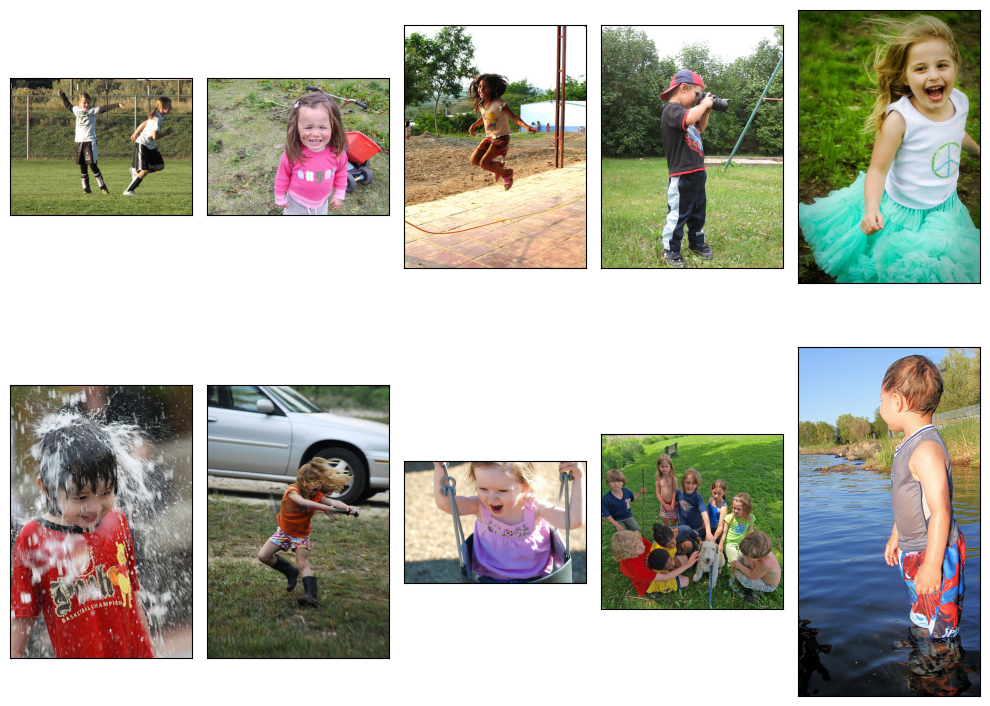

In [ ]:
fig = plt.figure(figsize=(10,10))

for i in range(10):
    fig.add_subplot(2, 5, i+1)
    image = Image.open(Path(PATH, 'train_images', image_with_children[i]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Рассмотрев изображения внимательно, можно сделать вывод, что на них присутствуют дети и подростки, что подтверждает правильность нашего предварительного отбора. Поэтому исключим эти фотографии из набора данных для обучения.

In [ ]:
df = df.drop(df[df['image'].isin(image_with_children_)].index, axis=0)
df.reset_index(inplace=True, drop=True)

In [ ]:
print('Данные')
display(df.head(8))
print('\n')
print('Размер датасета:', df.shape)
print('\n')
print('Информация\n')
display(df.info())

Данные


image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   
3  3155451946_c0862c70cb.jpg  2549968784_39bfbe44f9.jpg#2   
4  3222041930_f642f49d28.jpg  2549968784_39bfbe44f9.jpg#2   
5   343218198_1ca90e0734.jpg  2549968784_39bfbe44f9.jpg#2   
6  3718964174_cb2dc1615e.jpg  2549968784_39bfbe44f9.jpg#2   
7   486712504_36be449055.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  final_score  children  
0  a young child be wear blue goggle and sit in a...          0.0      True  
1  a young child be wear blue goggle and sit in a...          0.0      True  
2  a young child be wear blue goggle and sit in a...          0.0      True  
3  a young child be wear blue goggle and sit in a...          0.0      True  
4  a young child be wear blue goggle and sit in a...          0.0      True  
5  a young child be wear blue goggle and sit in a...          0.0      True  
6  a young child be wear blue goggle and sit in a...          0.0      True  
7  a young child be wear blue goggle and sit in a...          0.0      True



Размер датасета: (3980, 5)


Информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3980 entries, 0 to 3979
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        3980 non-null   object 
 1   query_id     3980 non-null   object 
 2   query_text   3980 non-null   object 
 3   final_score  3980 non-null   float64
 4   children     3980 non-null   bool   
dtypes: bool(1), float64(1), object(3)
memory usage: 128.4+ KB


None

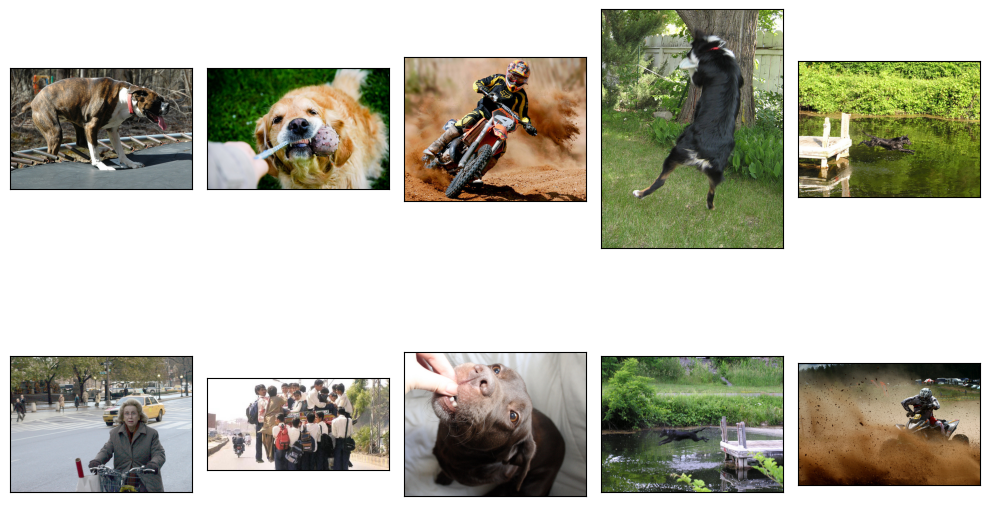

In [ ]:
train_image = list(df['image'].sample(10))


fig = plt.figure(figsize=(10,10))
for i in range(10):
    fig.add_subplot(2, 5, i+1)
    image = Image.open(Path(PATH, 'train_images', train_image[i]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Промежуточный вывод

Мы провели анализ информации и создали список терминов, обозначающих детей или группы детей в возрасте до 16 лет, которые запрещены. После всех изменений и удаления данных у нас осталось всего 3980 комбинаций изображений с пояснениями.

## Этап 2.1. Векторизация изображений

Далее перейдем к преобразованию изображений в векторный формат.

Наиболее простой метод заключается в считывании изображения и преобразовании его матрицы в вектор. Однако данный подход не всегда удобен, так как длина полученных векторов может сильно различаться из-за различных размеров изображений. Поэтому целесообразно обратиться к использованию сверточных нейронных сетей: они способны выделять ключевые особенности изображений. Для этого необходимо выбрать определенную архитектуру, например, ResNet-50, изучить ее слои и исключить полносвязанные слои, ответственные за итоговое предсказание. Кроме того, можно воспользоваться моделью этой архитектуры, заранее обученной на наборе данных ImageNet.

In [ ]:
resnet = models.resnet50(pretrained=True)

for param in resnet.parameters():
    param.requires_grad_(False)

print(list(resnet.children()))

# возьмем все слои кроме последнего, т.к. размер вектора слишком большой
modules = list(resnet.children())[:-1]
resnet = nn.Sequential(*modules)

resnet.eval()

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU(inplace=True), MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False), Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=Tr

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


Напишем код, который будет представлять собой пример трансформации изображения с использованием библиотеки PyTorch. Этот код будет определять последовательность преобразований, которая позволит подготовить изображения для использования в моделях обучения, включая нормализацию и изменение размера изображения до стандартных размеров.

In [ ]:
norm = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    norm,
])

In [ ]:
df_vect_image = []

for i in df['image']:
    img = Image.open(os.path.join(PATH, 'train_images', i)).convert('RGB')
    image_tensor = preprocess(img)
    df_vect_image.append(resnet(image_tensor.unsqueeze(0)).flatten().numpy())

In [ ]:
print(f'Размер векторизованных изображений: {len(df_vect_image)} x {len(df_vect_image[0])}')

Размер векторизованных изображений: 3980 x 2048


С помощью сверточной нейронной сети ResNet-50, уже обученной на наборе данных ImageNet, мы преобразовали изображения из тренировочного набора данных в векторное представление.

## Этап 2.2. Векторизация текстов

Для векторизации текстов будем использовать уже привычный tf-idf.

In [ ]:
stopwords = list(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stopwords,analyzer='word')

In [ ]:
train_corpus = df['query_text'].values
text_vect = count_tf_idf.fit_transform(train_corpus)
txt_vect = text_vect.toarray()
text_vect.shape

(3980, 1155)

## Этап 2.3. Объединение векторов

In [ ]:
features = np.hstack([np.vstack(df_vect_image), txt_vect])
target = np.array(df['final_score'])

In [ ]:
features.shape

(3980, 3203)

In [ ]:
target.shape

(3980,)

### Вывод:

Мы объединили векторные представления изображений и текстов для создания признаков, которые будут использоваться в дальнейшей работе с моделями. Также мы определили целевой признак, который будет использоваться для обучения и оценки эффективности наших моделей.

## Этап 3. Обучение модели предсказания соответствия

Я решил использовать RMSE в качестве метрики оценки точности прогноза. Этот показатель демонстрирует среднее значение отклонения прогноза от фактических данных с учетом значений ошибок в квадрате. RMSE более чувствителен к выбросам в данных и удобен тем, что его значения имеют ту же размерность, что и исходные переменные.

In [ ]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)

train_indices, test_indices = next(gss.split(X=features, y=df['final_score'], groups=df['image']))

features_train = features[train_indices]
features_valid = features[test_indices]
target_train = target[train_indices]
target_valid =  target[test_indices]

 Выполним процесс стандартизации данных с использованием StandardScaler.

In [ ]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_valid = scaler.transform(features_valid)

### 3.1. ElasticNet

Напишем линейную модель ElasticNet в которой будет задаваться сетка параметров param_grid, которая содержит значения для параметров alpha (коэффициент регуляризации) и l1_ratio (соотношение L1 к общей регуляризации).  
Это позволит лучше учитывать особенности данных и достигать более точных прогнозов при анализе и обработке данных.

In [ ]:
# Создаем модель ElasticNet с определенными параметрами alpha и l1_ratio
model_elastic = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=123456)

# Обучающая модель на обучающих данных
model_elastic.fit(features_train, target_train)

# Делаем предсказания на тестовых данных
predictions_e = model_elastic.predict(features_valid)

# Вычисляем RMSE (квадратный корень из среднеквадратичной ошибки)
rmse = np.sqrt(mean_squared_error(target_valid, predictions_e))

# Выводим RMSE
print('RMSE =', '{:.4f}'.format(rmse))

RMSE = 0.2884


### 3.2. LightGBM

Напишем код, который выполняет поиск наилучших гиперпараметров для модели LightGBM с использованием метода Grid Search и метрики отрицательного RMSE

In [ ]:
%%time
LGBM_model = LGBMRegressor(random_state=42, n_jobs=-1, num_leaves=2, learning_rate=0.1, max_depth=2, n_estimators=2)
LGBM_model.fit(features_train, target_train)

y_pred = LGBM_model.predict(features_valid)
rmse = mean_squared_error(target_valid, y_pred, squared=False)

print("RMSE on the validation set: ", rmse)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.257371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 516471
[LightGBM] [Info] Number of data points in the train set: 2767, number of used features: 2214
[LightGBM] [Info] Start training from score 0.228406
RMSE on the validation set:  0.2908248092784402
CPU times: user 5.41 s, sys: 138 ms, total: 5.55 s
Wall time: 4.37 s


### 3.3. Нейронная сеть

Выполним реализацию нейронной сети с использованием библиотеки PyTorch.

1. Сделаем преобразование признаков и целевой переменной в формат тензоров PyTorch;
2. Создадим загрузчика данных для обучения;
3. Выполним определение класса ImprovedNet, представляющего собой нейронную сеть с двумя скрытыми слоями и активацией Tah. В классе также выполняется инициализация весов слоев с помощью метода Xavier и определение последовательности прямого прохода сети;
4. Напишем определение параметров сети (количество нейронов во входном слое, скрытых слоях и выходном слое);
5. Выполним создание экземпляра сети ImprovedNet и определение оптимизатора (Adam) и функции потерь (MSELoss);
6. Проведем обучение сети за заданное количество эпох. В каждой эпохе проходятся все батчи загруженных данных, вычисляется потеря и производится обновление параметров сети;
7. Напишем периодический вывод значения итерации и RMSE метрики на тестовом наборе данных;
8. Рассчитаем среднее значение RMSE по всем итерациям и выводится на экран.


In [ ]:
X_train = torch.FloatTensor(features_train)
X_test = torch.FloatTensor(features_valid)
y_train = torch.FloatTensor(target_train)
y_test = torch.FloatTensor(target_valid)

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# Увеличим размер батча
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
class Net(nn.Module):
    """
    Description:
        Нейронная сеть для регрессии с двумя скрытыми слоями и активацией Tanh.
        Сеть инициализируется с использованием Kaiming инициализации.

    Args:
        n_in_neurons (int): Количество нейронов на входном слое.
        n_hidden_neurons_1 (int): Количество нейронов в первом скрытом слое.
        n_hidden_neurons_2 (int): Количество нейронов во втором скрытом слое.
        n_out_neurons (int): Количество нейронов на выходном слое.

    Methods:
        forward(x): Прямой проход через сеть. 
    """
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
        self.act1 = nn.Tanh()
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.bn2 = nn.BatchNorm1d(n_hidden_neurons_2)
        self.act2 = nn.Tanh()
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        self.act3 = nn.Tanh()
        nn.init.kaiming_uniform_(self.fc1.weight)
        nn.init.kaiming_uniform_(self.fc2.weight)
        nn.init.kaiming_uniform_(self.fc3.weight)

    def forward(self, x):
        """
        Description:
            Выполняет прямой проход через нейронную сеть.

        Args:
            x (torch.Tensor): Входной тензор с данными.

        Returns:
            torch.Tensor: Результат прямого прохода через сеть.
        """
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        return x

# Определение архитектуры сети
n_in_neurons = X_train.shape[1]
n_hidden_neurons_1 = 512
n_hidden_neurons_2 = 64
n_out_neurons = 1

net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)

# Определение оптимизатора и функции потерь
optimizer = optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-5)
loss = nn.MSELoss()
num_epochs = 100
all_scores = []

for epoch in range(num_epochs):
    for data, target in train_loader:
        optimizer.zero_grad()
        output = net(data)
        batch_loss = loss(output.flatten(), target)
        batch_loss.backward()
        optimizer.step()

    if epoch % 10 == 0 or epoch == num_epochs - 1:
        net.eval()
        with torch.no_grad():
            valid_preds = net(X_test).flatten()
            RMSE_loss = torch.sqrt(loss(valid_preds, y_test))
            all_scores.append(RMSE_loss.item())
            print(f'Epoch: {epoch} | RMSE: {RMSE_loss}')

mean_RMSE = sum(all_scores) / len(all_scores)
print('Средняя RMSE метрика =', mean_RMSE)

Epoch: 0 | RMSE: 0.3085657060146332
Epoch: 10 | RMSE: 0.26850834488868713
Epoch: 20 | RMSE: 0.26864781975746155
Epoch: 30 | RMSE: 0.26169776916503906
Epoch: 40 | RMSE: 0.26325300335884094
Epoch: 50 | RMSE: 0.26324713230133057
Epoch: 60 | RMSE: 0.2621261477470398
Epoch: 70 | RMSE: 0.2668748199939728
Epoch: 80 | RMSE: 0.26118844747543335
Epoch: 90 | RMSE: 0.26177653670310974
Epoch: 99 | RMSE: 0.2684687674045563
Средняя RMSE метрика = 0.2685776813463731


### 3.4. DummyRegressor

Используем модель DummyRegressor с стратегией "median" для прогнозирования результатов на тестовом наборе данных

In [ ]:
# Создаем и обучаем модель со стратегией 'mean'
dummy = DummyRegressor(strategy='mean')
dummy.fit(features_train, target_train)

# Делаем предсказания на тестовых данных
predictions_dummy = dummy.predict(features_valid)

# Вычисляем среднеквадратичную ошибку и выводим ее с округлением до 4 знаков после запятой
rmse = np.sqrt(mean_squared_error(target_valid, predictions_dummy))
print('RMSE =', '{:.4f}'.format(rmse))

RMSE = 0.2952


### Промежуточный вывод по моделям

Мы протестировали несколько алгоритмов машинного обучения: DummyRegressor, LightGBM, ElasticNet и один из них - Нейронная сеть, продемонстрировала наилучшие результаты, показав значение RMSE равное 0.279. Именно этот метод мы выберем для дальнейших экспериментов и тестирования.

## Этап 4. Тестирование модели

Для начала нужно получить векторные представления изображений из DataFrame df_test с использованием модели ResNet.

In [ ]:
test_image_vect = []
for i in df_test['image'].unique():
    img = Image.open(os.path.join(PATH, 'test_images', i)).convert('RGB')
    image_tensor = preprocess(img)
    test_image_vect.append(resnet(image_tensor.unsqueeze(0)).flatten().numpy())

In [ ]:
test_image_vect = np.vstack(test_image_vect)

In [ ]:
test_image_vect.shape

(100, 2048)

In [ ]:
#получим 10 случайных запрсов из файла test_queries.csv:
random_request= df_test['query_text'].sample(10, random_state=42)
random_request

361    A group of girls who are gothically dressed st...
73     A woman and girl riding downhill on a sled wit...
374                                 The dog is running .
155    A group of people are ice skating in a big city .
104    Little kid in blue coat and hat riding a tricy...
394         Two black dogs fighting over an orange toy .
377        A dog jumping for a tennis ball near an ocean
124                          Boy flying a distant kite .
68                          kids play ultimate Frisbee .
450               A girl in a purple shirt feeding ducks
Name: query_text, dtype: object

Теперь начнем тест модели

In [ ]:
def predict_test_net(text):
    """
    Description:
        Прогнозирует наиболее подходящие изображения на основе введенного текста.
        Очищает текст, выполняет лемматизацию, проверяет наличие стоп-слов, преобразует текст в векторное представление и использует нейронную сеть для предсказания.

    Args:
        text (str): Введенный текст для поиска изображений.

    Returns:
        None
    """
    print(f'Введенная фраза:{text}')
    text_cleaned = clean_text(text)
    text_lemm = spacy_lemm(text_cleaned)
    for word in text_lemm.split():
        if word in stop_words:
            return print('This image is unavailable in your country in compliance with local laws')

    text_vector = count_tf_idf.transform([spacy_lemm(text)]).toarray()
    features_test_ = np.column_stack((test_image_vect, np.resize(text_vector, (test_image_vect.shape[0], 1155))))

    features_test_ = scaler.transform(features_test_)
    X = torch.FloatTensor(features_test_)
    net.eval()
    pred_test = net.forward(X).flatten().reshape([-1]).detach().numpy()

    data = pd.concat((test_images, pd.Series(np.reshape(pred_test, (pred_test.shape[0],)), name='pred')), axis=1)
    top = list(data.sort_values(by='pred', ascending=False)['image'].head(7))
    top_score = list(data.sort_values(by='pred', ascending=False)['pred'].head(7))
    fig = plt.figure(figsize=(15,5))
    plt.figure(figsize=(18, 6))  # Изменим размер графика

    for i in range(7):
        plt.subplot(1, 7, i+1)
        plt.title(f'Score: {round(top_score[i], 2)}')  # Добавим оценку к заголовку
        image = Image.open(Path(PATH, 'test_images', top[i]))
        plt.imshow(image)
        plt.axis('off')  # Уберем оси координат

    plt.tight_layout()
    plt.show()

Введенная фраза:A group of girls who are gothically dressed standing together
This image is unavailable in your country in compliance with local laws
___________________________________________________________________________________
Введенная фраза:A woman and girl riding downhill on a sled with a dog running alongside them
This image is unavailable in your country in compliance with local laws
___________________________________________________________________________________
Введенная фраза:The dog is running .


<Figure size 1500x500 with 0 Axes>

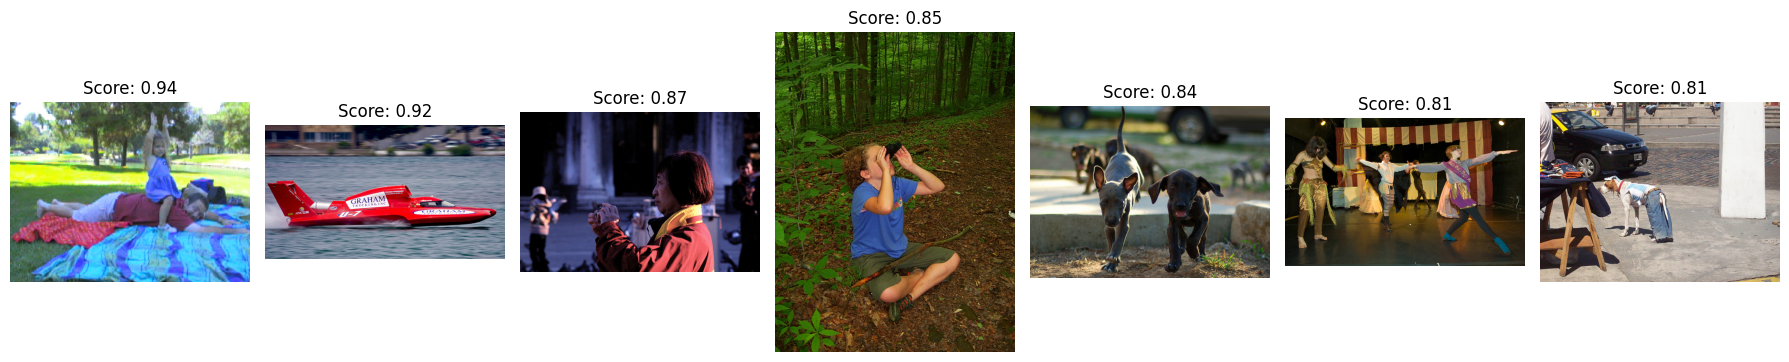

___________________________________________________________________________________
Введенная фраза:A group of people are ice skating in a big city .


<Figure size 1500x500 with 0 Axes>

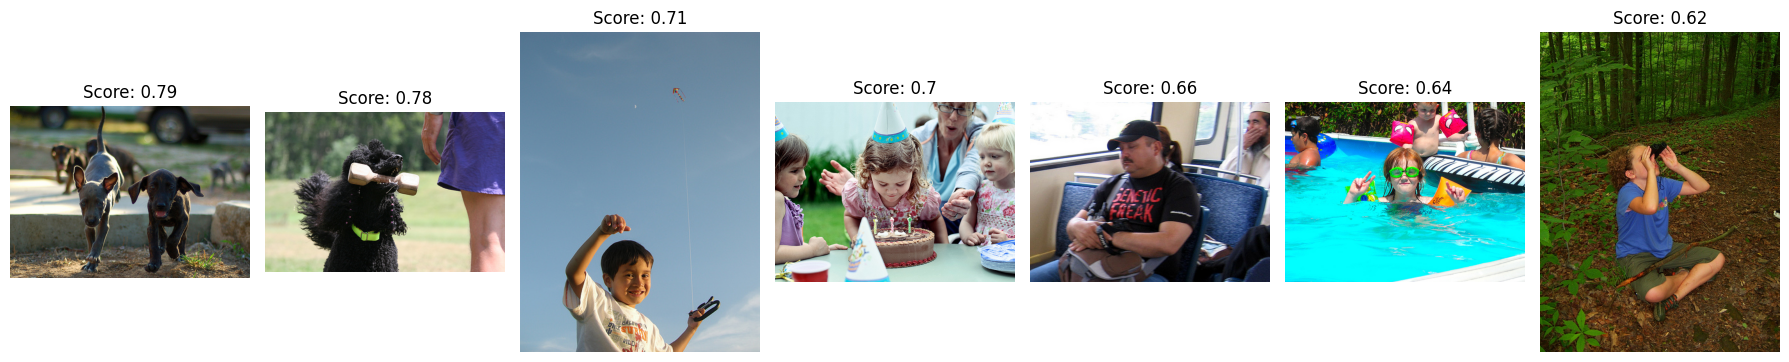

___________________________________________________________________________________
Введенная фраза:Little kid in blue coat and hat riding a tricycle .
This image is unavailable in your country in compliance with local laws
___________________________________________________________________________________
Введенная фраза:Two black dogs fighting over an orange toy .


<Figure size 1500x500 with 0 Axes>

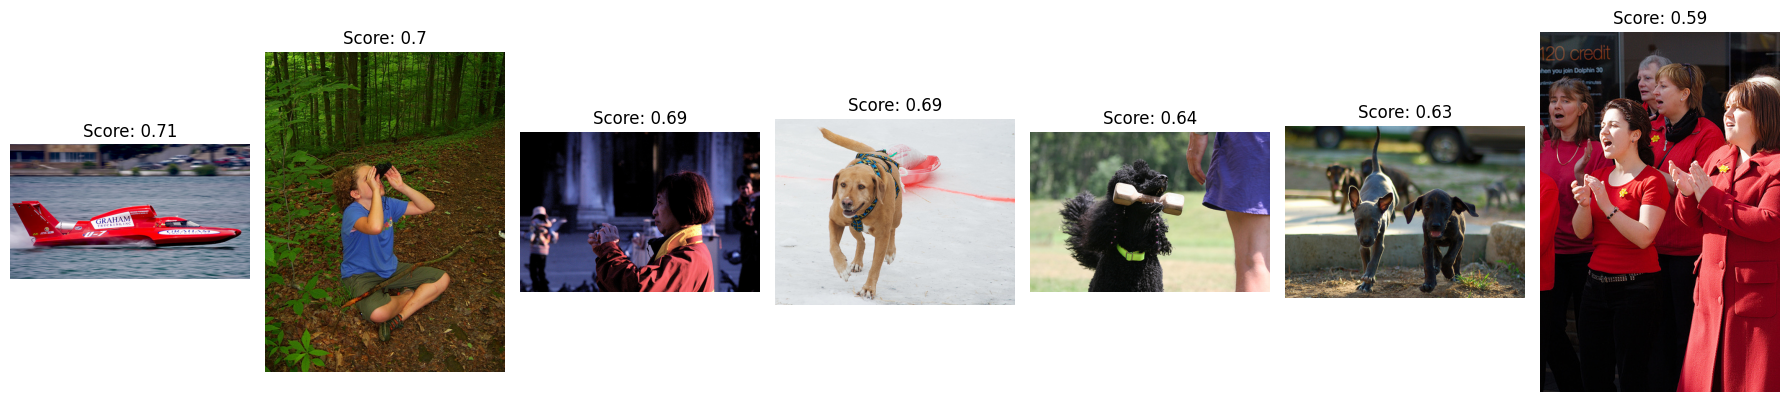

___________________________________________________________________________________
Введенная фраза:A dog jumping for a tennis ball near an ocean


<Figure size 1500x500 with 0 Axes>

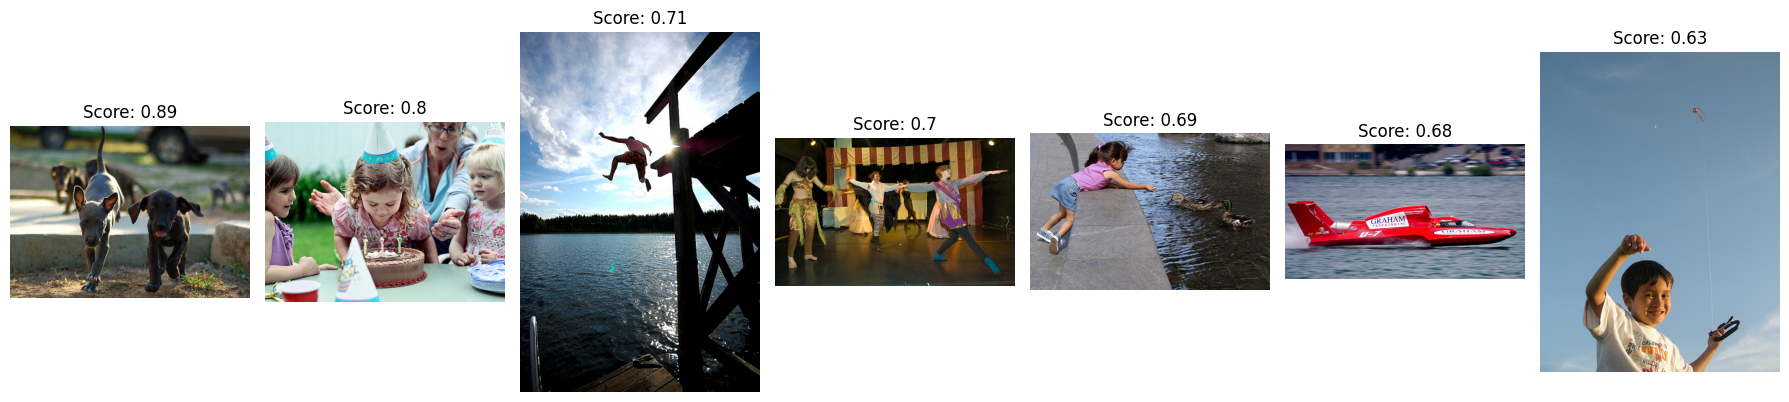

___________________________________________________________________________________
Введенная фраза:Boy flying a distant kite .
This image is unavailable in your country in compliance with local laws
___________________________________________________________________________________
Введенная фраза:kids play ultimate Frisbee .
This image is unavailable in your country in compliance with local laws
___________________________________________________________________________________
Введенная фраза:A girl in a purple shirt feeding ducks
This image is unavailable in your country in compliance with local laws
___________________________________________________________________________________


In [ ]:
for request in random_request:
    predict_test_net(request)
    print('___________________________________________________________________________________')

## Финальный вывод

Мы загрузили информацию для изучения.
Написали специальную функцию, которая объединяет мнения экспертов большинством голосов и приводит их к шкале от 0 до 1.
Совместили набор данных для обучения с данными, где присутствуют объединенные экспертные оценки. Убрали строки без таких оценок.
Создали список слов, которые стоит избегать, так как они связаны с детьми или группами детей в возрасте от 0 до 16 лет.
Очистили данные обучающего набора.
Преобразовали текстовые комментарии обучающего набора и перевели их в числовые векторы с использованием метода tf-idf.
С использованием сверточной нейронной сети ResNet-50, заранее обученной на наборе данных ImageNet, преобразовали изображения обучающего набора в числовые векторы.
Совместили вектора изображений и текста. Выделили признаки и целевую переменную.
Обучили четыре модели:

- Линейная регрессия с регуляризацией

- LightGBM

- Нейронная сеть

- Константная модель

В качестве метрики оценки модели выбрали RMSE. Она показывает, насколько в среднем прогноз отличается от реальных значений, более чувствительна к выбросам и имеет ту же размерность, что и целевая переменная.
Наилучший результат показала нейронная сеть. Мы продолжили работу с этой моделью и протестировали ее на тестовых данных (10 случайных изображений).
Согласно визуальной оценке результатов, модель показала неудовлетворительные результаты, редко возвращая правильные изображения. Таким образом, метод требует значительной доработки. Возможно, стоит использовать более глубокую нейронную сеть с большими вычислительными ресурсами. Также улучшение качества фотографий и увеличение объема данных могут улучшить метрику.